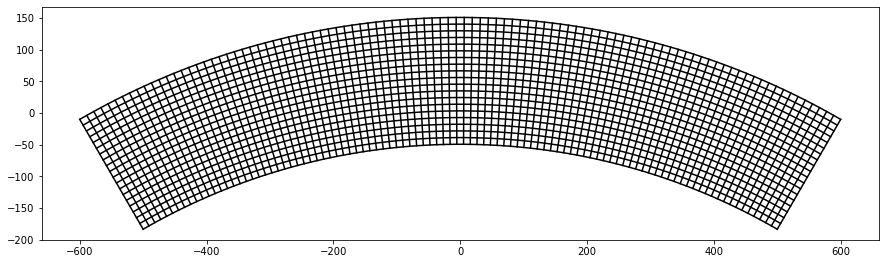

In [82]:
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygridgen import grid

R1 = 10.e5       # Inner radius of arc [m]
R2 = 12.e5        # Outer radius of arc [m]
theta = 60.0     # Sweep of arc [deg]
nR = 20          # number of grid points in radial direction
nT = 100         # number of grid points in theta direction

phi, r = np.meshgrid( np.linspace(-theta/2., theta/2, nT) * np.pi / 180.0, 
                      np.linspace(R1, R2, nR) )

x = r * np.sin(phi)
y = r * np.cos(phi)

x -= x.mean()
y -= y.mean()

grd = grid.CGrid(x, y)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(grd.x_vert/1e3, grd.y_vert/1e3, '-k');
plt.plot(grd.x_vert.T/1e3, grd.y_vert.T/1e3, '-k');
ax.set_aspect(1.0)

In [63]:
grd.x_u.shape, grd.x_v.shape

((19, 98), (18, 99))

In [178]:
eta_rho, xi_u = grd.x_u.shape
eta_v, xi_rho = grd.x_v.shape
eta_psi, xi_psi = grd.x_psi.shape

periods = 30
time = pd.date_range("2000-01-01", periods=periods)

u = np.ones((periods, eta_rho, xi_u)) * 0.05
v = np.zeros((periods, eta_v, xi_rho))

ds = xr.Dataset(
    data_vars=dict(
        u=(['time', 'eta_rho', 'xi_u'], u),
        v=(['time', 'eta_v', 'xi_rho'], v),
    ),
    coords=dict(
        x_u=(['eta_rho', 'xi_u'], grd.x_u),
        y_u=(['eta_rho', 'xi_u'], grd.y_u),
        x_v=(['eta_v', 'xi_rho'], grd.x_v),
        y_v=(['eta_v', 'xi_rho'], grd.y_v),
        x_psi=(['eta_psi', 'xi_psi'], grd.x_psi),
        y_psi=(['eta_psi', 'xi_psi'], grd.y_psi),
        time=("time", time),
    ),
)

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/y_/vp5v56qd4nj5b07f89_ww3fnsbfrqc/T/parcels-1924621036/93aa0eb1297c97a1849bae11945f2fd1_0.so


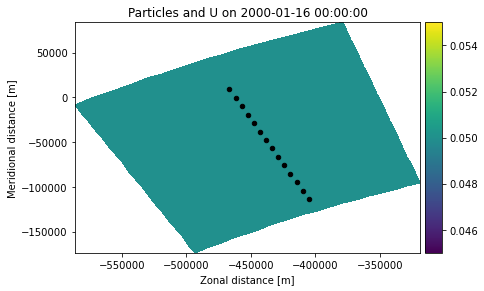

In [180]:
variables = {"U": "u", "V": "v"}
dimensions = {
    "U": {"lon": "x_u", "lat": "y_u", "time": "time"},
    "V": {"lon": "x_v", "lat": "y_v", "time": "time"},
}
# dimensions = {"lon": "x_psi", "lat": "y_psi", "time": "time"}
# dimensions = {
#     "U": {"lon": "x_psi", "lat": "y_psi", "time": "time"},
#     "V": {"lon": "x_psi", "lat": "y_psi", "time": "time"},
# }

fieldset = FieldSet.from_xarray_dataset(ds, variables, dimensions, 
                                        mesh='flat',
#                                         interp_method='cgrid_velocity',
                                        gridindexingtype='mitgcm')


pset = ParticleSet(fieldset=fieldset, 
                   pclass=JITParticle,
                   lon=grd.x_rho[:, 5],  
                   lat=grd.y_rho[:, 5])   

output_file = pset.ParticleFile(name="foo.nc", outputdt=timedelta(hours=1))

pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=15),    # the total length of the run
             dt=timedelta(minutes=5),      # the timestep of the kernel
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}
            )

pset.show(field=fieldset.U)

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/y_/vp5v56qd4nj5b07f89_ww3fnsbfrqc/T/parcels-1924621036/977803dc39e19093374a907f91f8bab0_0.so
/Users/hetl729/miniconda3/envs/parcels/lib/python3.7/site-packages/parcels/plotting.py:224: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = ax.pcolormesh(plotlon[0], plotlat[0], d, cmap=pc_cmap)


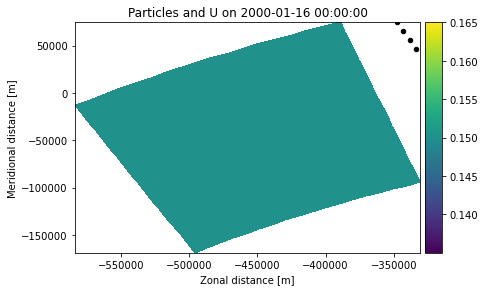

In [182]:
eta_psi, xi_psi = grd.x_psi.shape

periods = 30
time = pd.date_range("2000-01-01", periods=periods)

u = np.ones((periods, eta_psi, xi_psi)) * 0.15
v = np.zeros((periods, eta_psi, xi_psi))

ds = xr.Dataset(
    data_vars=dict(
        u=(['time', 'eta_psi', 'xi_psi'], u),
        v=(['time', 'eta_psi', 'xi_psi'], v),
    ),
    coords=dict(
        x_psi=(['eta_psi', 'xi_psi'], grd.x_psi),
        y_psi=(['eta_psi', 'xi_psi'], grd.y_psi),
        time=("time", time),
    ),
)

variables = {"U": "u", "V": "v"}
dimensions = {
    "U": {"lon": "x_psi", "lat": "y_psi", "time": "time"},
    "V": {"lon": "x_psi", "lat": "y_psi", "time": "time"},
}

fieldset = FieldSet.from_xarray_dataset(ds, variables, dimensions, 
                                        mesh='flat',
                                        interp_method='cgrid_velocity',
                                        gridindexingtype='mitgcm')


pset = ParticleSet(fieldset=fieldset, 
                   pclass=JITParticle,
                   lon=grd.x_rho[:, 5],  
                   lat=grd.y_rho[:, 5])   

output_file = pset.ParticleFile(name="foo.nc", outputdt=timedelta(hours=1))

pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=15),    # the total length of the run
             dt=timedelta(minutes=5),      # the timestep of the kernel
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}
            )

pset.show(field=fieldset.U)

19

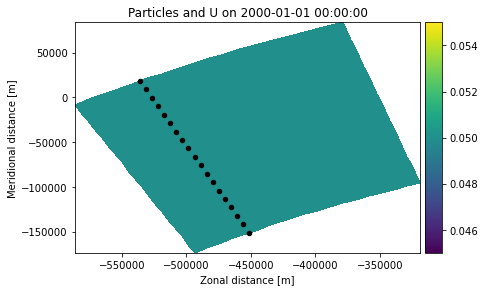

In [159]:
output_file = pset.ParticleFile(name="foo.nc", outputdt=timedelta(hours=1))

pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=15),    # the total length of the run
             dt=timedelta(minutes=5),      # the timestep of the kernel
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}
            )

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/y_/vp5v56qd4nj5b07f89_ww3fnsbfrqc/T/parcels-1924621036/cf27d332464685e6c8d8c4415d32ff80_0.so


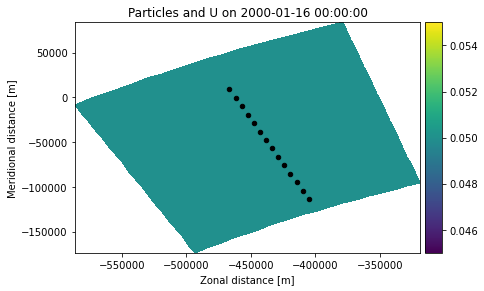

In [160]:
pset.show(field=fieldset.U)